In [1]:
# load necessary libraries

import time
import pandas as pd
import pickle as pk
import numpy as np
import os
from datetime import datetime

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

start_time = time.time()

# declare contants
kfold = 10
base_dir = '~\\project\\ExploratoryDataAnalysis'
excel_file = 'aiml_test_data.xlsx'
filename = os.path.join(base_dir, excel_file)

In [2]:
# -------------------------------------------------------------------------
# Helper modules for Descriptive Statistics
# -------------------------------------------------------------------------    
def get_redundant_pairs(df):
        pairs_to_drop = set()
        cols = df.columns
        for i in range(0, df.shape[1]):
            for j in range(0, i+1):
                pairs_to_drop.add((cols[i], cols[j]))
        return pairs_to_drop

def get_top_abs_correlations(df, n=5): 
        au_corr = df.corr().unstack()
        labels_to_drop = get_redundant_pairs(df)
        au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
        return au_corr[0:n]

def corrank(X):
        import itertools
        df = pd.DataFrame([[(i,j), 
                   X.corr().loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],
                   columns=['pairs','corr'])
        print(df.sort_values(by='corr',ascending=False))
        print()

In [3]:
# -------------------------------------------------------------------------    
# load dataset
# ------------------------------------------------------------------------- 
def load_dataset(filename):
    dataset = pd.read_excel(filename, sheet_name='Sheet1', header=0, na_values='NaN')       

    print(dataset.shape);    print(dataset.head(5));    print(dataset.columns)

    feature_names = ['port_of_loading', 'port_of_discharge', 'HSCODE', 'is_coc',
       'cargo_weight', 'expected_time_of_departure', 'teu']
    target = 'paid_amount'

    return feature_names, target, dataset

# execute the function
feature_names, target, dataset = load_dataset(filename)    

(10000, 8)
  port_of_loading port_of_discharge  HSCODE  is_coc  cargo_weight  \
0           KRMAS             JPNGO  585089    True     22.502334   
1           KRPUN             JPNGO  200244   False     23.879217   
2           KRPUS             JPTYO  159150    True      7.049077   
3           KRMAS             JPKNZ  784932   False     17.018100   
4           KRPUS             JPTRG  592176   False     18.331793   

  expected_time_of_departure  teu  paid_amount  
0                 2022-04-13    7   671.033860  
1                 2023-03-12    7  1061.490580  
2                 2022-09-28    1   136.779387  
3                 2022-04-17    7   776.686991  
4                 2022-03-13    7   907.256793  
Index(['port_of_loading', 'port_of_discharge', 'HSCODE', 'is_coc',
       'cargo_weight', 'expected_time_of_departure', 'teu', 'paid_amount'],
      dtype='object')


In [4]:
# -------------------------------------------------------------------------    
# find missing values in dataset if exists
# -------------------------------------------------------------------------
def find_missing_value(feature_names, target, dataset):
        # Count Number of Missing Value on Each Column    
        print('\nCount Number of Missing Value on Each Column: ')        
        print(dataset.isnull().sum(axis=0))

# execute the function
find_missing_value(feature_names, target, dataset)        


Count Number of Missing Value on Each Column: 
port_of_loading               0
port_of_discharge             0
HSCODE                        0
is_coc                        0
cargo_weight                  0
expected_time_of_departure    0
teu                           0
paid_amount                   0
dtype: int64


In [5]:
# -------------------------------------------------------------------------    
# factorize text values & Sort by 
# -------------------------------------------------------------------------
def factorzie_text_values(dataset):
    ports_of_loading, pol = pd.factorize(dataset['port_of_loading'])
    dataset['pol'] = pd.DataFrame(ports_of_loading)

    ports_of_discharge, pod = pd.factorize(dataset['port_of_discharge'])
    dataset['pod'] = pd.DataFrame(ports_of_discharge)

    dataset['is_coc'] = dataset['is_coc'].astype(int)

    date_string = dataset['expected_time_of_departure'].dt.strftime('%Y%m%d')
    dataset['date'] = date_string.astype(int)

    dataset.sort_values(by=['expected_time_of_departure'], axis=0, ascending=True, inplace=True)
    
    print(dataset.head(5))

    return pol, pod, dataset


pol, pod, dataset = factorzie_text_values(dataset)


     port_of_loading port_of_discharge  HSCODE  is_coc  cargo_weight  \
1149           KRPUN             JPTRG  629092       0      7.520364   
7559           KRMAS             JPTYO  606212       1     15.950675   
2299           KRPUN             JPOSA  286258       1     12.774403   
2368           KRPUN             JPTRG  656268       1     12.935366   
885            KRPUN             JPTYO  834404       0     10.691159   

     expected_time_of_departure  teu  paid_amount  pol  pod      date  
1149                 2022-01-01    4   534.229651    1    3  20220101  
7559                 2022-01-01    5   478.725798    0    1  20220101  
2299                 2022-01-01    4   370.456017    1    4  20220101  
2368                 2022-01-01    5   493.714229    1    3  20220101  
885                  2022-01-01    6   692.056874    1    1  20220101  


In [6]:
# 1. 각 컬럼의 의미

# pol 선착항 ['KRMAS: 한국 마산항', 'KRPUN: 한국 부산신항으로 추정', 'KRPUS: 한국 부산항', 'KRPTK: 한국 평택항']
print(pol)
# pod 도착항 ['JPNGO: 일본 나고야항', 'JPTYO: 일본 도쿄항', 'JPKNZ: 일본 카자나와항', 'JPTRG: 일본 츠루가항', 'JPOSA: 일본 오사카항']
print(pod)
# HSCODE: HS CODE는 국제통일 상품분류체계에 따라 대외 무역거래 상품을 총괄적으로 분류한 품목 분류 코드 
#   이 HS CODE는 총 6자리로 구성되어 있으며, 우리나라는 물건의 세부 분류를 위해 4자리를 추가해 사용하고 있음
# coc(Carrier Own Container): 선사 소유의 컨테이너로 대부분의 경우 coc로 진행됨. 선사에게 정해진 시간 및 장소에서 픽업하고 반납해야 함.
# soc(Shipper Own Container): 화주 소유의 컨테이너로 시간에 의한 픽업 및 반납에 대한 제약이 없어 시간적으로 효율적이고 선착 후 일시적 창고 역할까지 가능.
# cargo_weight: 운송 화물의 무게
# expected_time_of_departure: 도착 예정 일시
# teu(twenty-foot equivalent unit): 20 피트 길이의 컨테이너 크기를 부르는 단위로 컨테이너선이나 컨테이너 부두 등에서 주로 쓰인다. 
#   20 피트 표준 컨테이너의 크기를 기준으로 만든 단위로 배나 기차, 트럭 등의 운송 수단간 용량을 비교를 쉽게하기 위해 만들어졌다.
# paid_amount: 매출

Index(['KRMAS', 'KRPUN', 'KRPUS', 'KRPTK'], dtype='object')
Index(['JPNGO', 'JPTYO', 'JPKNZ', 'JPTRG', 'JPOSA'], dtype='object')


In [7]:
# -------------------------------------------------------------------------
# descriptive statistics and correlation matrix
# -------------------------------------------------------------------------
def data_descriptiveStats(feature_names, target, dataset):
        # Count Number of Missing Value on Each Column    
        print(); print('Count Number of Missing Value on Each Column: ')        
        print(); print(dataset[feature_names].isnull().sum(axis=0))
        print(); print(dataset[target].isnull().sum(axis=0))    
    
        # Get Information on the feature variables
        print(); print('Get Information on the feature variables: ')            
        print(); print(dataset[feature_names].info())
        print(); print(dataset[feature_names].describe())
    
        # correlation
        print(); print(dataset[feature_names].corr())    
    
        # Ranking of Correlation Coefficients among Variable Pairs
        print(); print("Ranking of Correlation Coefficients:")    
        corrank(dataset[feature_names])

        # Print Highly Correlated Variables
        print(); print("Highly correlated variables (Absolute Correlations):")
        print(); print(get_top_abs_correlations(dataset[feature_names], 8))
    
        # Get Information on the target    
        print(); print(dataset[target].describe())    
        print(); print(dataset.groupby(target).size())    

feature_names = ['pol', 'pod', 'HSCODE', 'is_coc', 'cargo_weight', 'date', 'teu', 'paid_amount']
data_descriptiveStats(feature_names, target, dataset)


Count Number of Missing Value on Each Column: 

pol             0
pod             0
HSCODE          0
is_coc          0
cargo_weight    0
date            0
teu             0
paid_amount     0
dtype: int64

0

Get Information on the feature variables: 

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1149 to 3279
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pol           10000 non-null  int64  
 1   pod           10000 non-null  int64  
 2   HSCODE        10000 non-null  int64  
 3   is_coc        10000 non-null  int32  
 4   cargo_weight  10000 non-null  float64
 5   date          10000 non-null  int32  
 6   teu           10000 non-null  int64  
 7   paid_amount   10000 non-null  float64
dtypes: float64(2), int32(2), int64(4)
memory usage: 625.0 KB
None

                pol           pod         HSCODE       is_coc  cargo_weight  \
count  10000.000000  10000.000000   10000.000000  10000.00000  1

C:\Users\AquaCo\AppData\Local\Temp\ipykernel_3796\2065603572.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()



BOX plot of each Numerical features


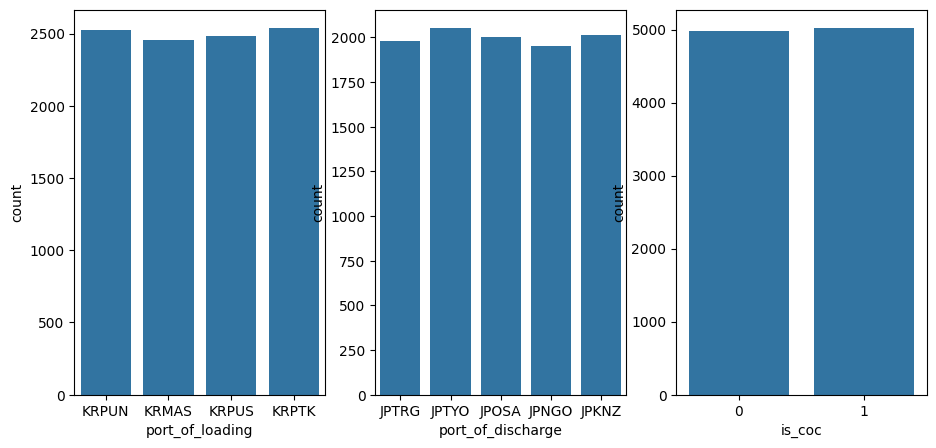

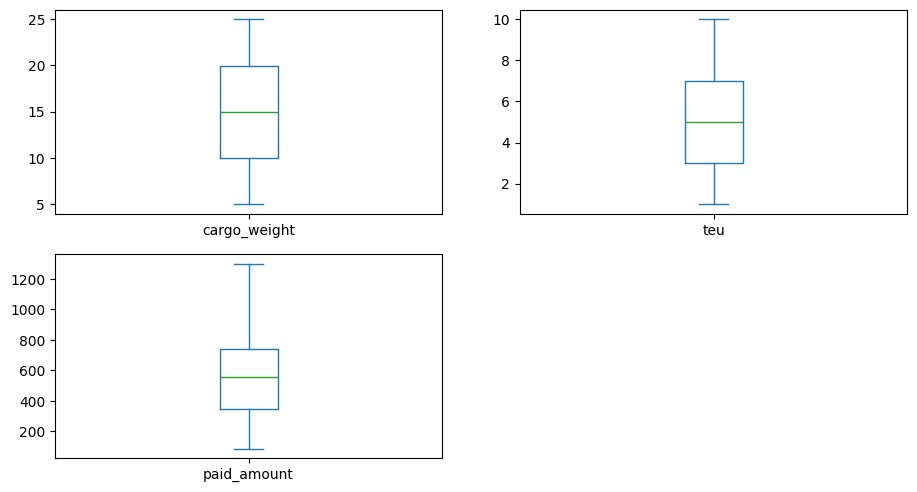


Histogram of each Numerical Feature


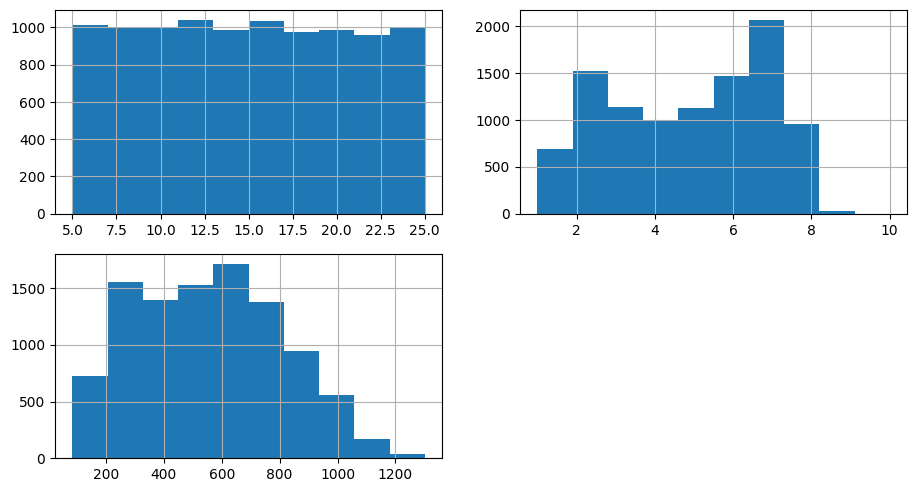


Correlation Matrix of All Numerical Features


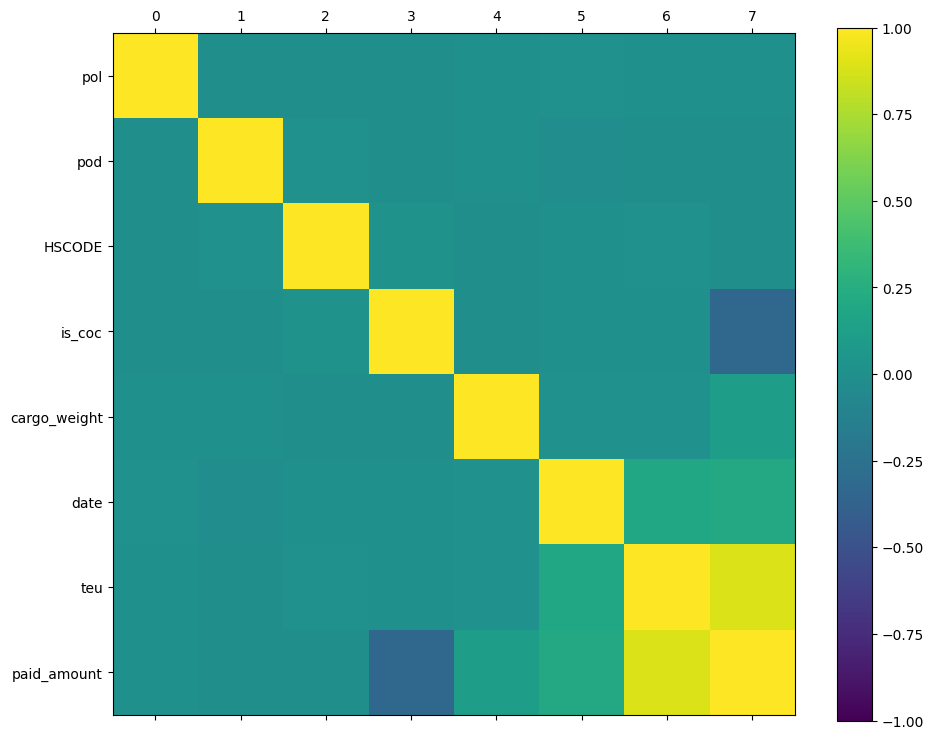


Correlation plot of Numerical features
                   pol       pod    HSCODE    is_coc  cargo_weight      date  \
pol           1.000000 -0.003227 -0.007308 -0.000579      0.005928  0.014858   
pod          -0.003227  1.000000  0.011032 -0.003629      0.003381 -0.019971   
HSCODE       -0.007308  0.011032  1.000000  0.019655     -0.004936  0.004679   
is_coc       -0.000579 -0.003629  0.019655  1.000000     -0.004003  0.003090   
cargo_weight  0.005928  0.003381 -0.004936 -0.004003      1.000000  0.011595   
date          0.014858 -0.019971  0.004679  0.003090      0.011595  1.000000   
teu           0.006300 -0.003574  0.008900  0.001270      0.009588  0.192412   
paid_amount   0.004216 -0.000718 -0.001401 -0.327807      0.115817  0.208216   

                   teu  paid_amount  
pol           0.006300     0.004216  
pod          -0.003574    -0.000718  
HSCODE        0.008900    -0.001401  
is_coc        0.001270    -0.327807  
cargo_weight  0.009588     0.115817  
date       

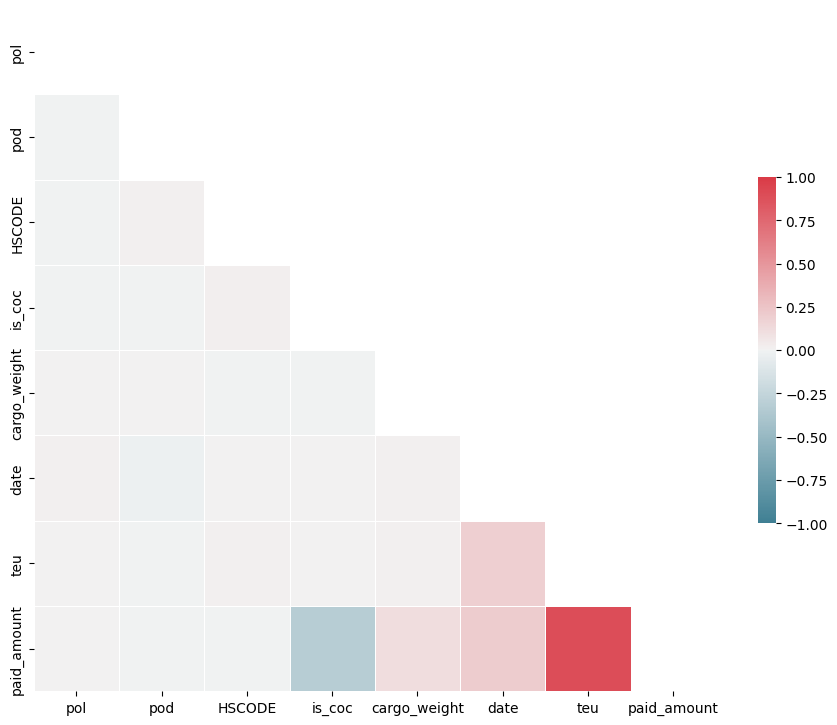


Scatter Matrix Plot


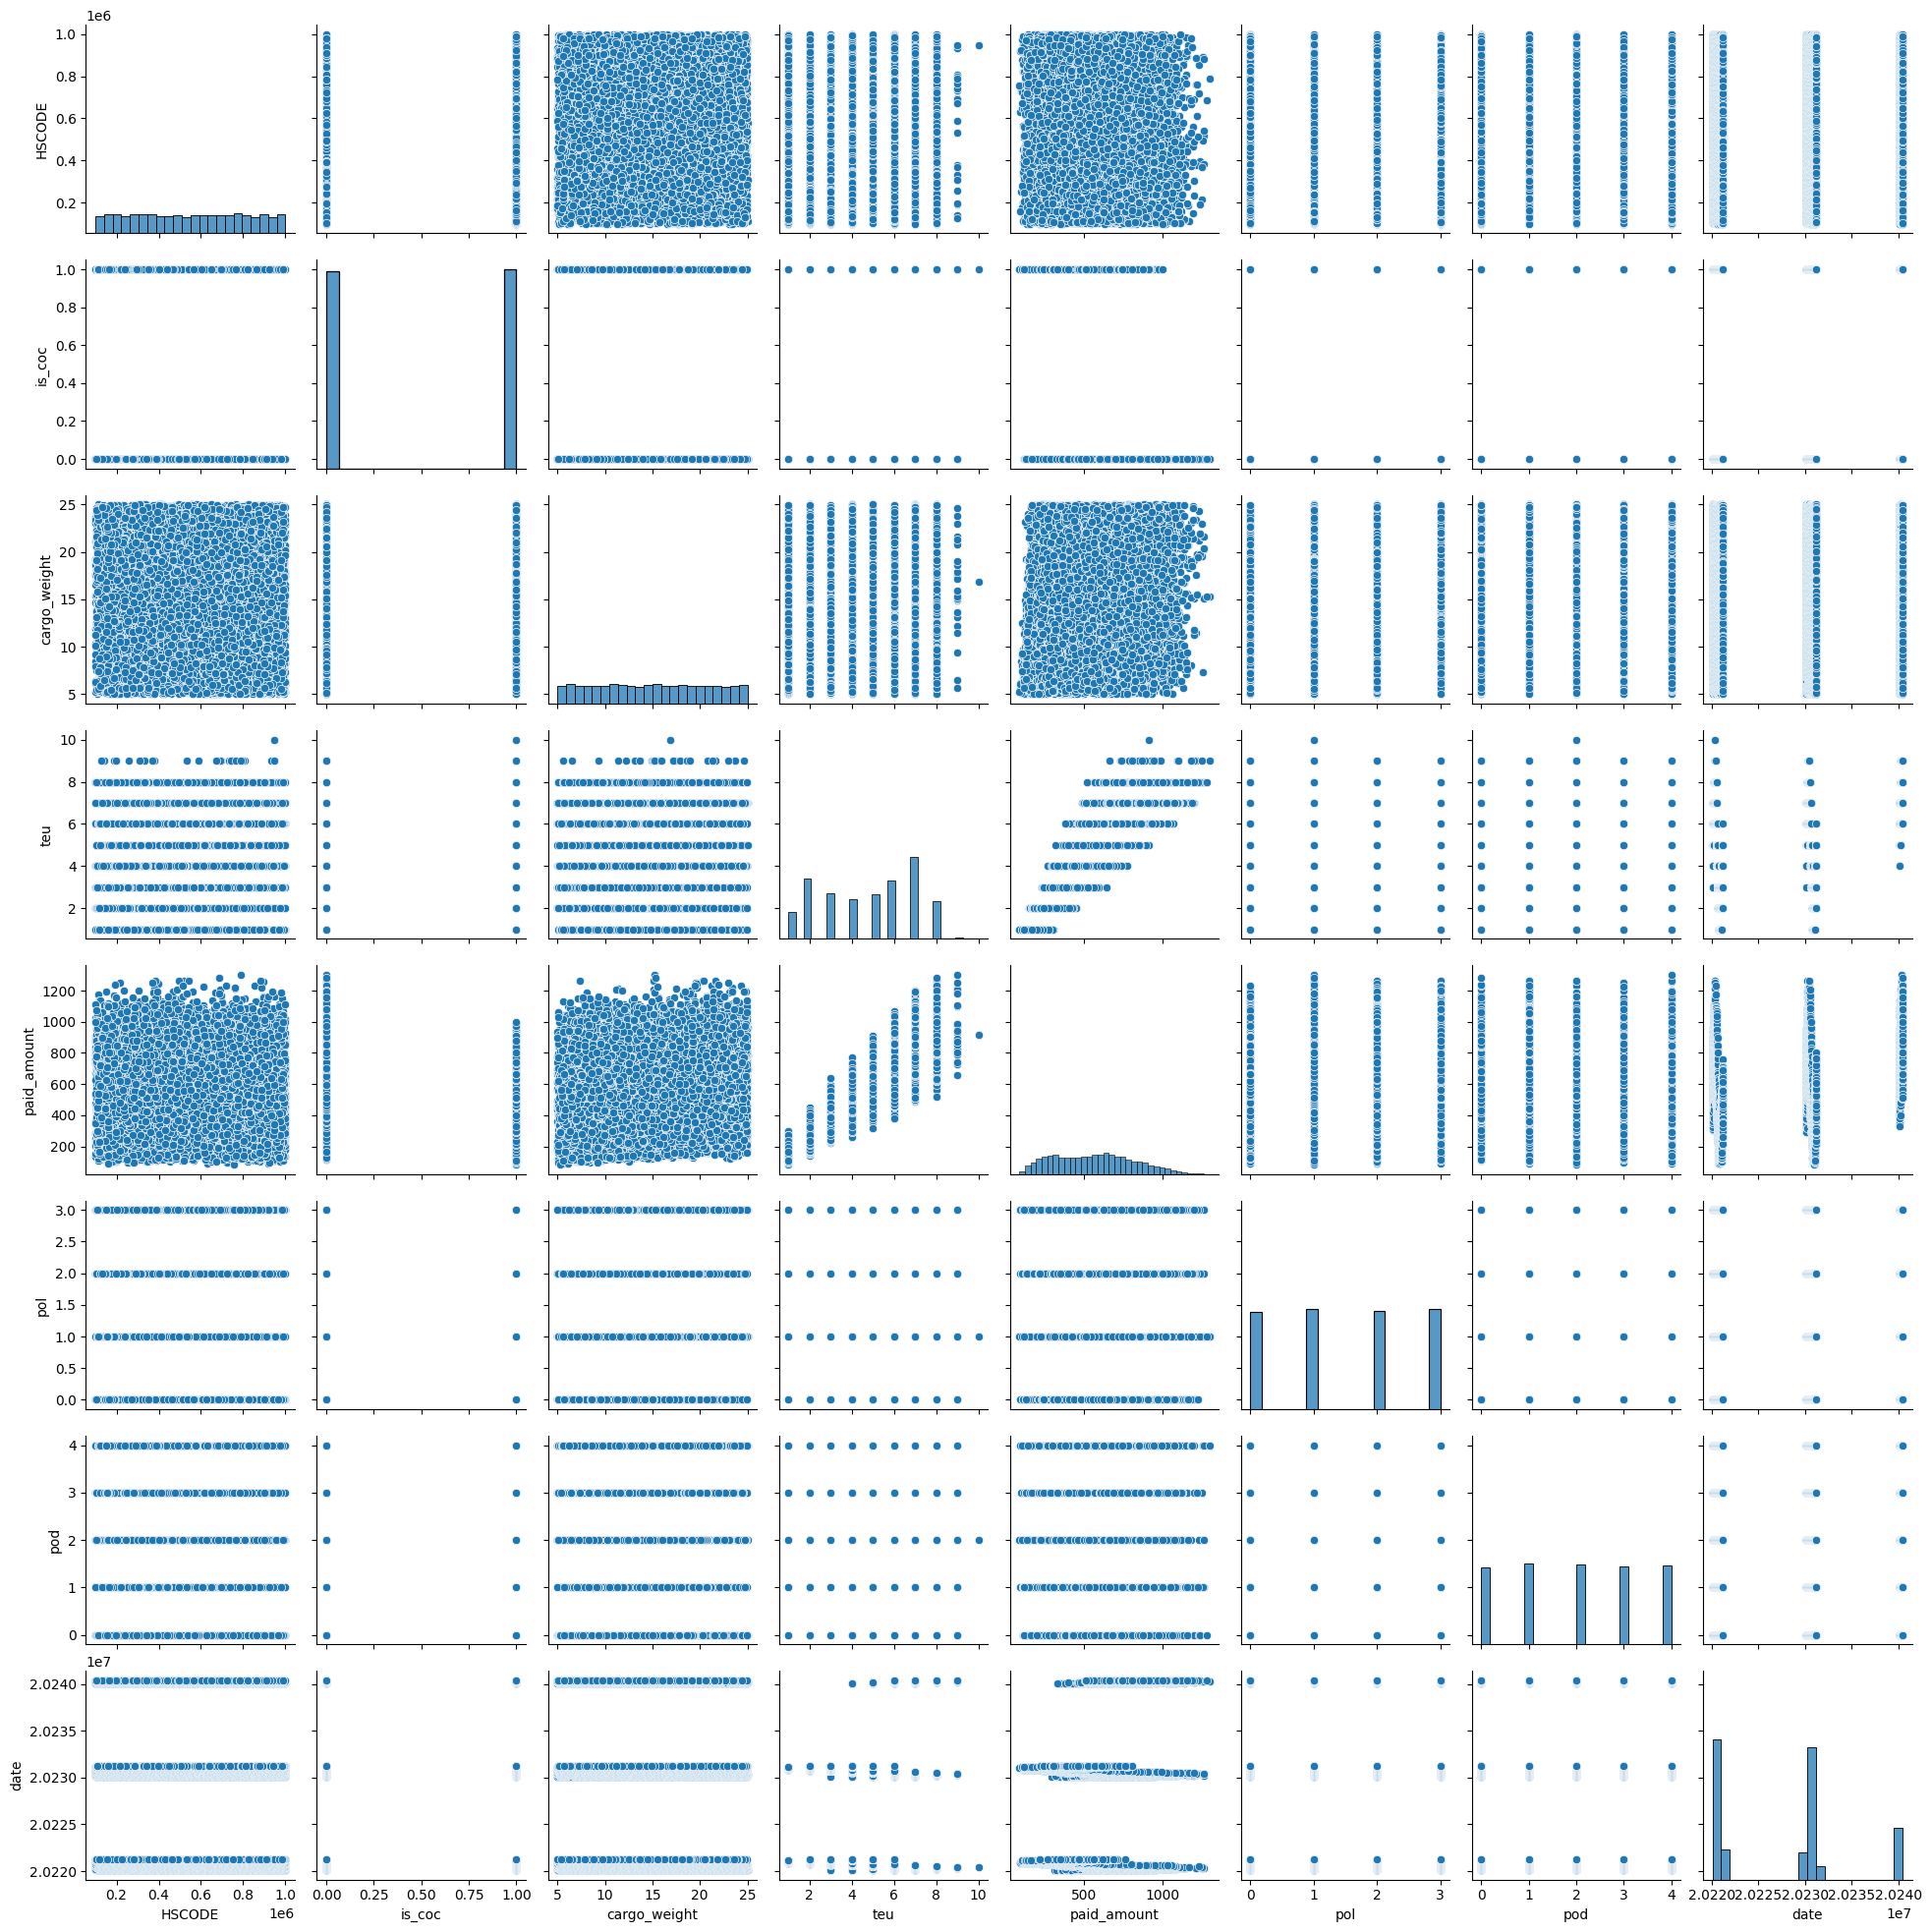


PIE Chart of for Target: 


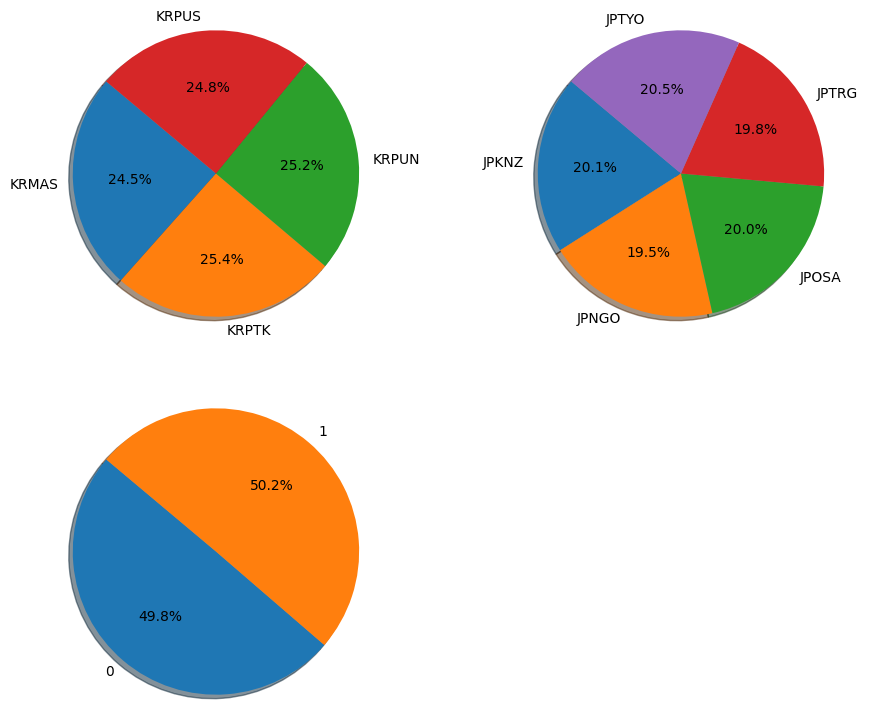

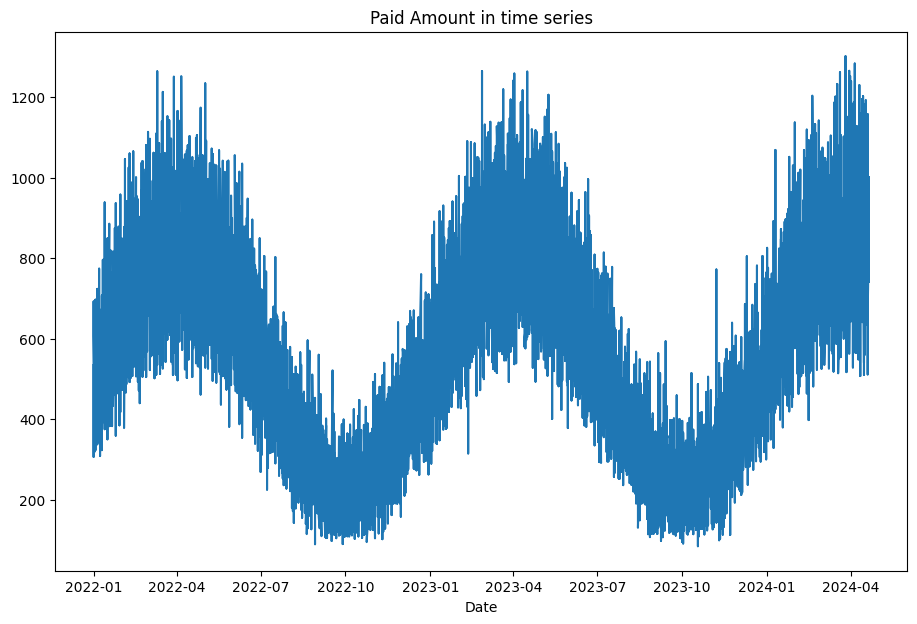

In [8]:
# -------------------------------------------------------------------------
# data visualisation and correlation graph
# -------------------------------------------------------------------------
def data_visualization(feature_names, target, dataset):
        fig, ax = plt.subplots(1,3, figsize=(11, 5))
        sns.countplot(x='port_of_loading', data=dataset, ax=ax[0])
        sns.countplot(x='port_of_discharge', data=dataset, ax=ax[1])
        sns.countplot(x='is_coc', data=dataset, ax=ax[2])
        fig.show()
        
        feature_names = ['cargo_weight', 'teu', 'paid_amount']
        feature_num = len(feature_names)
        # BOX plots USING box and whisker plots
        i = 1
        print(); print('BOX plot of each Numerical features')
        plt.figure(figsize=(11, 9))     
        for col in feature_names:
            plt.subplot(feature_num,2,i)
            dataset[col].plot(kind='box', subplots=True, sharex=False, sharey=False)
            i += 1
        plt.show()    
    
        # USING histograms
        j = 1
        print(); print('Histogram of each Numerical Feature')
        plt.figure(figsize=(11, 9))     
        for col in feature_names:
            plt.subplot(feature_num,2,j)
            dataset[col].hist()
            j += 1
        plt.show()

        feature_names = ['pol', 'pod', 'HSCODE', 'is_coc', 'cargo_weight', 'date', 'teu', 'paid_amount']
        feature_num = len(feature_names)
        # correlation matrix
        print(); print('Correlation Matrix of All Numerical Features')   
        fig = plt.figure(figsize=(11,9))
        ax = fig.add_subplot(111)
        cax = ax.matshow(dataset[feature_names].corr(), vmin=-1, vmax=1, interpolation='none')
        fig.colorbar(cax)
        ticks = np.arange(0,feature_num,1)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks, labels=feature_names)
        plt.show()

        # Correlation Plot using seaborn
        print(); print("Correlation plot of Numerical features")
        # Compute the correlation matrix
        corr = dataset[feature_names].corr()
        print(corr)
        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9))
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin= -1.0, center=0, square=True, 
                    linewidths=.5, cbar_kws={"shrink": .5})
        plt.show()    
    
        # PairPlot using seaborn
        print(); print('Scatter Matrix Plot')
        sns.pairplot(dataset)
        plt.show()
    
        # Pie chart for Categorical Variables
        print(); print('PIE Chart of for Target: ')
        plt.figure(figsize=(11,9)) 
        i = 1
        target = ['port_of_loading', 'port_of_discharge', 'is_coc']
        for colName in target:
            labels = []; sizes = []
            df = dataset.groupby(colName).size()
            for key in df.keys():
                labels.append(key)
                sizes.append(df[key])
            # Plot PIE Chart with %
            plt.subplot(2,2,i)
            plt.axis('on')
            plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                            labelleft=True, labeltop=True, labelright=False, labelbottom=False)        
            plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
            plt.axis('equal')
            i += 1
            # plt.savefig('Piefig.pdf', format='pdf')
        plt.show()

        # paid_amount in time series
        plt.figure(figsize=(11,7))
        plt.plot(dataset['expected_time_of_departure'], dataset['paid_amount'])
        plt.title("Paid Amount in time series")
        plt.xlabel("Date")
        plt.show()  

data_visualization(feature_names, target, dataset)

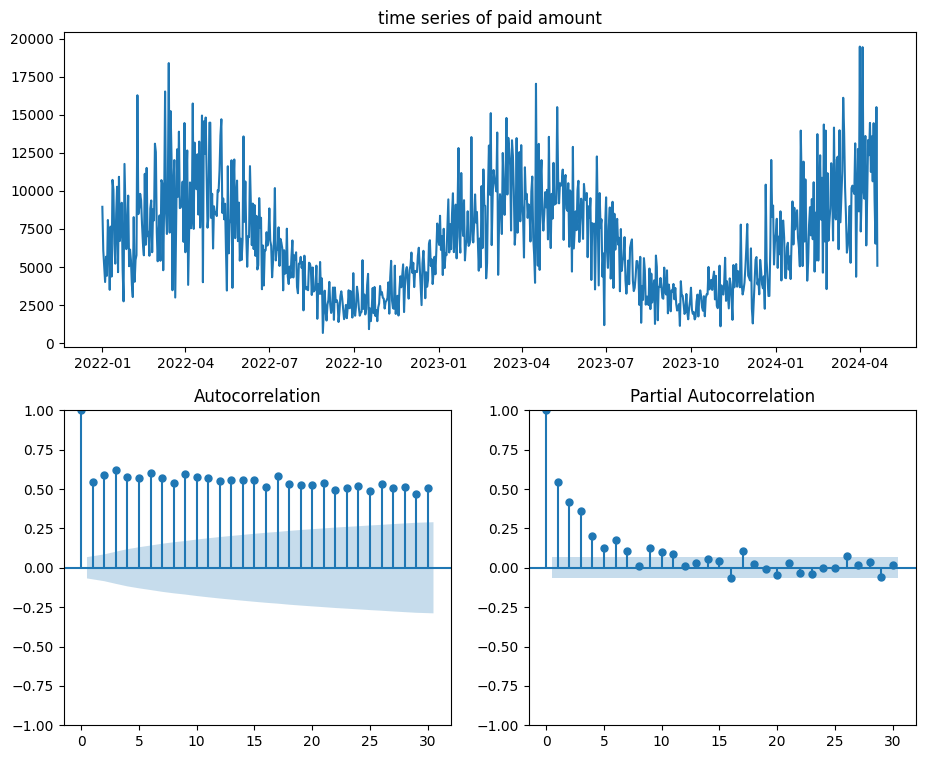

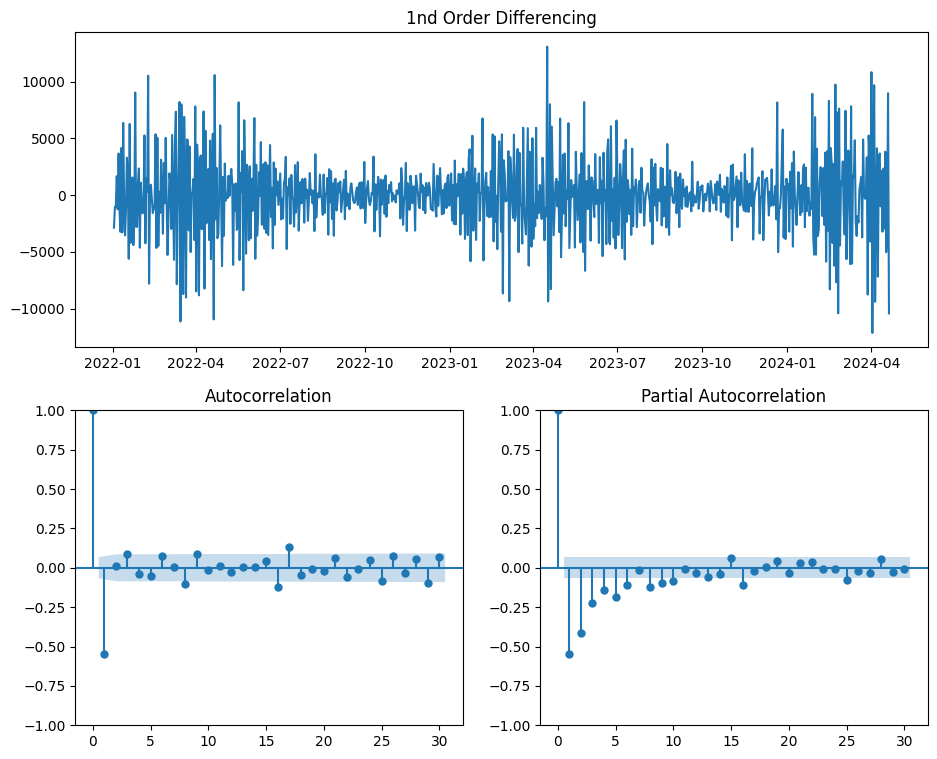

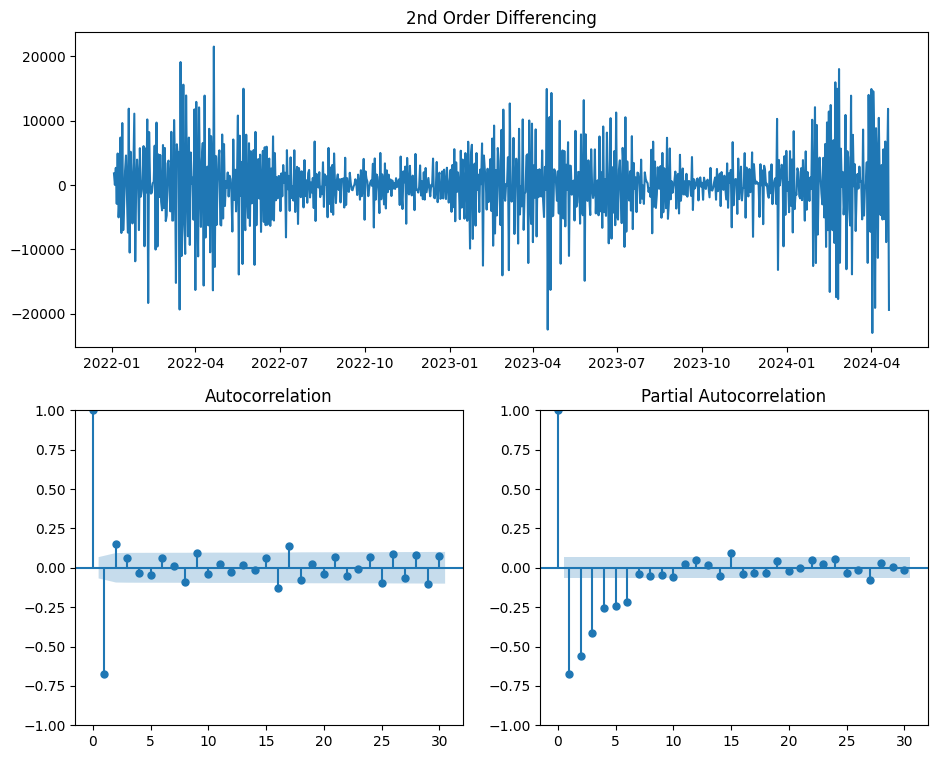

In [9]:
# ACF and PACF 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ts = dataset.groupby('expected_time_of_departure')['paid_amount'].sum()

f = plt.figure(figsize=(11,9))
ax1 = f.add_subplot(211)
ax1.set_title('time series of paid amount')
ax1.plot(ts)

ax2 = f.add_subplot(223)
plot_acf(ts, ax=ax2)
ax3 = f.add_subplot(224)
plot_pacf(ts, ax=ax3)
plt.show()

# find diff - 1st order differencing
f = plt.figure(figsize=(11,9))
ax11 = f.add_subplot(211)
ax11.set_title('1nd Order Differencing')
ax11.plot(ts.diff())

ax12 = f.add_subplot(223)
plot_acf(ts.diff().dropna(), ax=ax12)
ax13 = f.add_subplot(224)
plot_pacf(ts.diff().dropna(), ax=ax13)
plt.show()

# 2nd order differencing
f = plt.figure(figsize=(11,9))
ax21 = f.add_subplot(211)
ax21.set_title('2nd Order Differencing')
ax21.plot(ts.diff().diff().dropna())

ax22 = f.add_subplot(223)
plot_acf(ts.diff().diff().dropna(), ax=ax22)
ax23 = f.add_subplot(224)
plot_pacf(ts.diff().diff().dropna(), ax=ax23)
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts)
print('p-value: ', result[1])

result = adfuller(ts.diff().dropna())
print('p-value: ', result[1])

result = adfuller(ts.diff().diff().dropna())
print('p-value: ', result[1])

p-value:  0.7231661086972937
p-value:  1.0062369822018729e-20
p-value:  8.638952855482795e-26


c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            paid_amount   No. Observations:                  841
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -7690.333
Date:                Sun, 28 Apr 2024   AIC                          15388.666
Time:                        19:59:30   BIC                          15407.600
Sample:                    01-01-2022   HQIC                         15395.923
                         - 04-20-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0505      0.221      0.229      0.819      -0.382       0.483
ma.L1         -1.0756      0.216     -4.988      0.000      -1.498      -0.653
ma.L2          0.1881      0.194      0.972      0.3

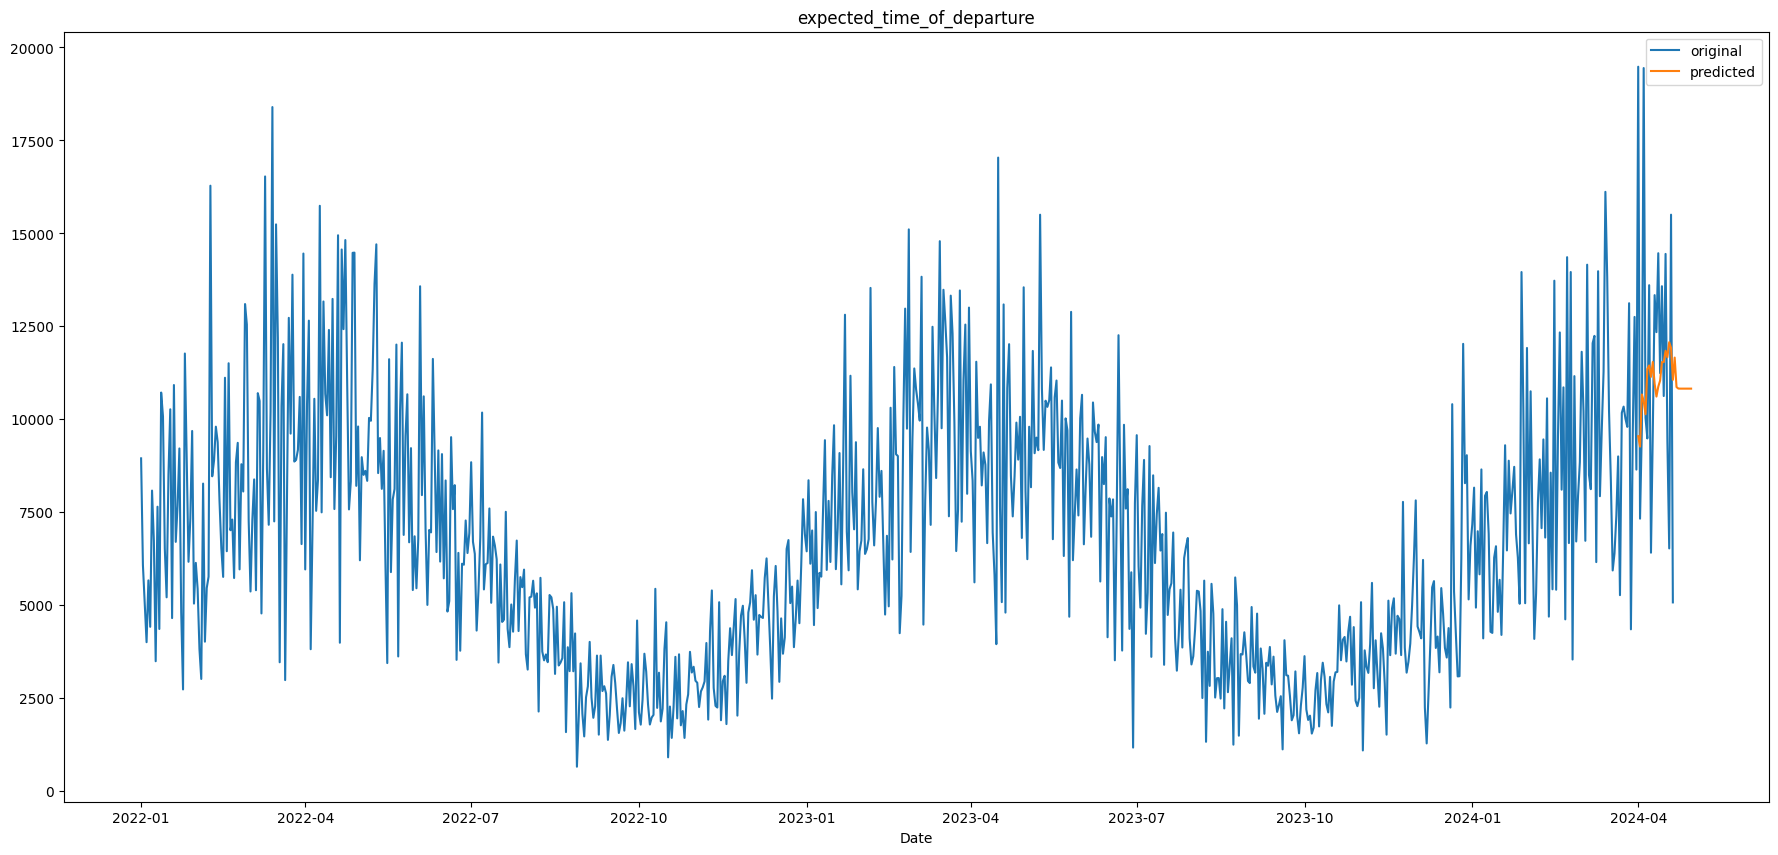

In [11]:
# ARIMA LIBRARY
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(ts, order=(1,1,2))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# predict
forecast = model_fit.predict(start="2024-04-01", end="2024-04-30")

# visualization
plt.figure(figsize=(22,10))
plt.plot(ts, label = "original")
plt.plot(forecast, label = "predicted")
plt.title("expected_time_of_departure")
plt.xlabel("Date")
plt.legend()
plt.show()

c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


error:  5315994.509443


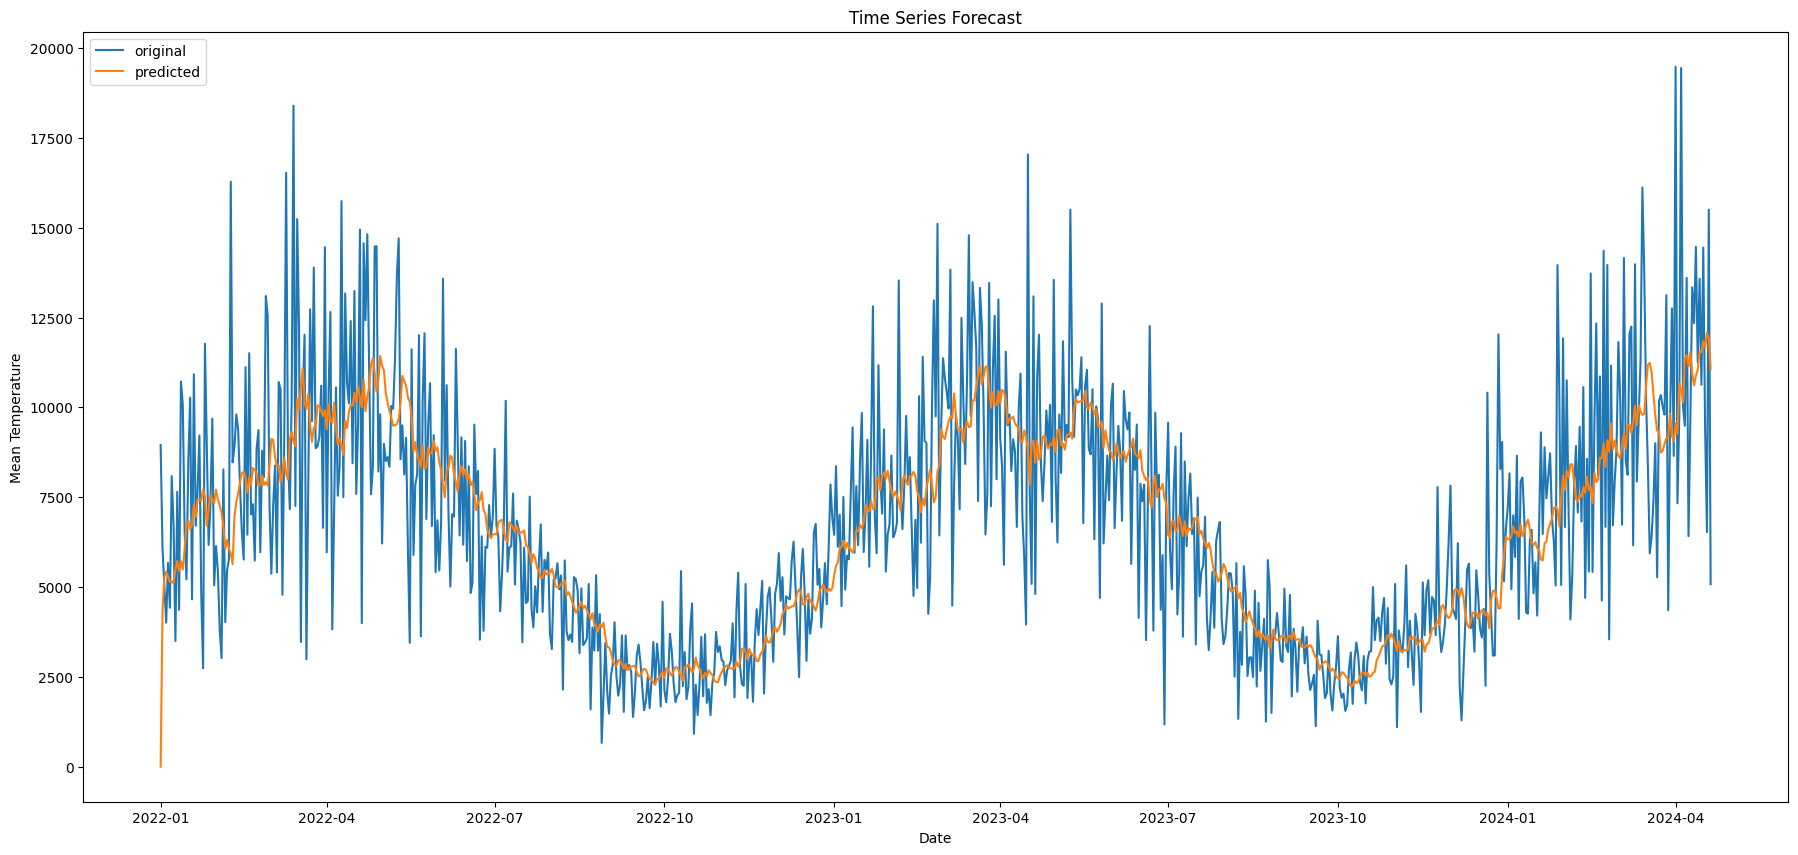

In [12]:
# predict all path
from sklearn.metrics import mean_squared_error
# fit model
model2 = ARIMA(ts, order=(1,1,2)) # (ARMA) = (1,0,1)
model_fit2 = model2.fit()
forecast2 = model_fit2.predict()
error = mean_squared_error(ts, forecast2)
print("error: " ,error)
# visualization
plt.figure(figsize=(22,10))
plt.plot(ts, label = "original")
plt.plot(forecast2,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.savefig('graph.png')

plt.show()

In [18]:
# ------------------
# save the model
# ------------------
def save_model(model):
        with open('paid_amount_model.pickle', 'wb') as f: 
            pk.dump(model, f)

save_model(model) 

In [19]:
# ------------------------------------------------
# Load the model from disk and make predictions
# ------------------------------------------------
def final_prediction(feature_names, filename):
        # load model
        f = open('paid_amount_model.pickle', 'rb')
        model = pk.load(f); f.close()
        
        # load dataset
        dataset = pd.read_excel(filename, sheet_name='Sheet1', header=0, na_values='NaN')       


final_prediction(feature_names, filename)        

In [15]:
print()
print("Required Time %s seconds: " % (time.time() - start_time))


Required Time 15.97323751449585 seconds: 
